In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats

<br>

# Motivation

---

Many machine learning algorithms take the the assumption that the data points are independent and identically distributed.

This is a reasonable assumption if we try to classify images that were reassembled by crawling the internet. But some sequence of data points are not independent are in fact highly correlated:

* the successive images in a movies (should you see a cat, seeing a cat at the next frame is very likely)
* the sequence of positions in a game such as Chess (the board will overall be similar)
* the words in a sentence in NLP (due to the structure of the sentence and the context)
* the prices of a financial product over time (made of tendencies + noise)

Models that are suited for independent sample data points will stuggle here. Decoding a sentence word by word, not taping into the extraordinary sources of correlations between words, will likely lead to bad performances.

We can sometimes adapt the situation. For instance in Deep Reinforcement Learning, a Q-network might be given mini-batch of randomly sampled board situation for a game like Go (so that the i.i.d. assumption is approximated as best as possible). But in general, this will not be possible.

We will thefore now look at models that work with the assumption that data points have some relationship between the element $x_n$ and the elements $x_1 \dots x_{n-1}$ that preceeded it.

<br>

# Markov Processes
---

Assuming that a data point $x_n$ depends on the values $x_1 \dots x_n$ that preceeds it leads to two problems. The first one is that the distribution is of a different shape at each new points (more and more parameters), the second one is that the distribution complexity grows exponentially. Markov processes are one way to solve this problem.

<br>

### Definition

The **markov assumption** says that each data point is **dependent only a fixed number of previous points** and not on the points that preceeded it. We call such a random process an order-K markov process. 

&emsp; $p(x_n | x_{n-1} \dots x_1) = p(x_n | x_{n-1} \dots x_{n-k})$

A markov process is **homogenous** if the probability $p(x_n|x_{n-1} \dots x_{n-k})$ remains constant over time, which means that the data generative process that creates the data, its distribution, stays the same.

An order-1 homogeneous markov process is usually what we talk about when mentioning markov processes: the point $x_n$ only depend on the value of the previous point $x_{n-1}$ and stays the same over time. For discrete finite random variables, such processes can be encoded by a **transition matrix**.

<br>

### Stationary distribution

If $\Omega$ is the universe of values the random variables $x_i$ can take, a **stationary distribution** is a probability distribution $p$ over $\Omega$, such that this distribution remains the same between $x_n$ and $x_{n+1}$ (and consequently forever after that).

For an order-1 homogeneous markov process on a discrete finite random variable, encoded by the transition matrix $M$, a stationary distribution is therefore a vector $p$ that describes a distribution ($\sum_i p_i = 1$ and $p_i \ge 0$) such that $M p = p$, or in other words, an **eigenvector** of $M$.

Under some assumptions (such as ergodicity), a markov process will have one and only one stationary distribution, and will converge toward that distribution.

In [2]:
# TODO - finding the stationary distribution by exponentiation (which can be made quick by diagonalisation)

<br>

# State Space Models
---

The choice of the order in a Markov Process is a difficult trade-off. A big order will make the model more powerful but also more expensive. Even for big orders, the inability to depend on the whole past sequence remains a limitation. State space models offer an alternative way to **depend on the whole past observation sequence, while remaining tractable**.

<br>

### Definition

A state space model is a model based on **latent variables** (unobserved variables) $z_1 \dots z_n$ which follow a Markov Process. There is one latent variable by data point that we observe. The observations $x_1 \dots x_n$ themselves do not form a Markov Process themselves, but are instead generated using an **emission process** $p(x_i|z_i)$.

**Hidden Markov Models** are state space models in which the **latent variables are discrete random variables**. The emision distribution might not be a discrete distribution, but can be a gaussian, parameterized on the latent variable for instance.

**Linear Dynamical System** are state space models in which the **latent variables are continuous random variables**, for instance vectors of reals. Because it is easier when $p(x_n|x_{n-1})$ keeps the same shape for each $n$, this conditional distribution is often chosen to be a distribution of the exponential family, and in particular a gaussian.

<br>

### Forward-Backward algorithm

We have a sequence of observations $x_1 \dots x_N$ and we want to infer the next element of the sequence $x_{N+1}$. To do so, we must first be able to deduce $z_N$, which require us to deduce the sequence of latent variable states $z_1 \dots z_N$. Then we can do a prediction for $z_{N+1}$ and then use the emission distribution $p(x_{N+1}|z_{N+1})$ to deduce $x_{N+1}$.

The algorithm to deduce the hidden variable is known as **alpha-beta** algorithm and use dynamic programming to deduce the $N$ latent variables in $O(N K^2)$ where $K$ is the number of states of $z$:

&emsp; $\displaystyle p(z_n|X) = \frac{p(X|z_n)p(z_n)}{p(X)} = \frac{\alpha(z_n) \beta(z_n)}{p(X)}$
&emsp; with:
&emsp; $\alpha(z_n) = p(x_1 \dots x_n, z_n)$
&emsp; $\beta(z_n) = p(x_{n+1} \dots x_N | z_n)$

&emsp; $\displaystyle \alpha(z_{n}) = p(x_n|z_n) \sum_{z_{n-1}} \alpha(z_{n-1}) p(z_n|z_{n-1})$
&emsp; initialized with
&emsp; $\forall z_1, \; \alpha(z_{1}) = p(x_1|z_1) p(z_1)$

&emsp; $\displaystyle \beta(z_{n}) = \sum_{z_{n+1}} p(x_{n+1}|z_{n+1}) \beta(z_{n+1}) p(z_{n+1}|z_n)$
&emsp; initialized with
&emsp; $\forall z_N, \; \beta(z_{N}) = 1$

Using this the $\alpha$ left to right pass, we can easily deduce the probability of the last state $z_N$. Using the $\beta$ right to left pass, we can easily deduce the probability of any $z_n$ in the middle (for instance, to find a missing value in the middle).

Please note that **this requires to know the probability distributions** $p(z_n|z_{n-1})$ and $p(x_n|z_n)$. This makes this inference mechanism useful for the **E-step of the EM algorithm** (to deduce the $z_n$ associated with the $x_n$ to afterward maximize expectation of the log joint probability distribution). It also makes it useful for **decoding a noisy message if you know the probability distrubtion of the source and the noise**.

<br>

### Proof of forward-backward algorithm

We can use the *d-separation* criteria (blocking path in a Bayesian network) to prove that:

&emsp; $\displaystyle p(z_n|X) = \frac{p(X|z_n)p(z_n)}{p(X)} = \frac{p(x_1 \dots x_n| z_n) p(x_{n+1} \dots x_N| z_n) p(z_n)}{p(X)}$

We can then use the same *d-separation* criteria to demonstrate the recursion for $\alpha$:

&emsp; $\alpha(z_n) = p(x_1 \dots x_n| z_n) p(z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) p(x_1 \dots x_{n-1}|z_n) p(z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) p(x_1 \dots x_{n-1},z_n)$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(x_1 \dots x_{n-1},z_n| z_{n-1}) p(z_{n-1})$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(z_n|z_{n-1}) p(x_1 \dots x_{n-1}| z_{n-1}) p(z_{n-1})$

&emsp; $\alpha(z_n) = p(x_n|z_n) \sum_{z_{n-1}} p(z_n|z_{n-1}) \alpha(z_{n-1})$

We can do similarly for $\beta$.

<br>

### Example

We have latent variable that is a bit, that flips with probability 20%. The sequence starts at (0.5, 0.5). We add white noise to the message, and we want to decode the message:

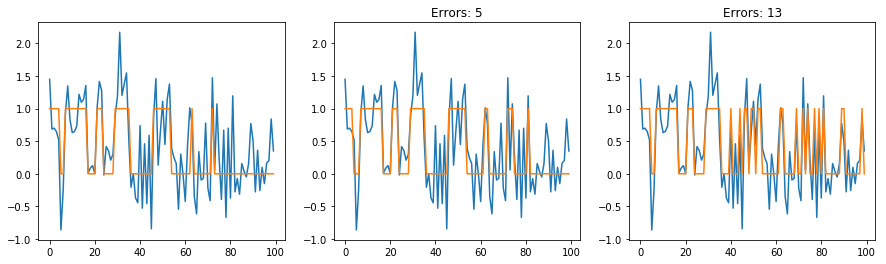

In [18]:
noise_scale=0.5
train_zs = np.cumsum(np.random.choice([0, 1], p=[0.8, 0.2], size=100)) % 2
train_xs = train_zs + np.random.normal(loc=0., scale=noise_scale, size=train_zs.shape)


def hmm_decoding(train_xs):
    alphas = np.full(shape=(len(train_zs), 2), fill_value=0.5)
    for i in range(1, len(alphas)):
        for d in range(2):
            p_x_z = stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i])
            alphas[i][d] = p_x_z * (alphas[i-1][d] * 0.8 + alphas[i-1][1-d] * 0.2)

    betas = np.full(shape=(len(train_zs), 2), fill_value=1.0)
    for i in reversed(range(0, len(betas)-1)):
        for d in range(2):
            betas[i][d] = betas[i+1][d] * 0.8 * stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i+1])
            betas[i][d] += betas[i+1][1-d] * 0.2 * stats.norm(loc=1-d, scale=noise_scale).pdf(train_xs[i+1])

    p_zn = alphas * betas
    return np.argmax(p_zn, axis=-1)


def naive_decoding(train_xs):
    p_x_z = np.full(shape=(len(train_zs), 2), fill_value=0.5)
    for i in range(len(p_x_z)):
        for d in range(2):
            p_x_z[i][d] = stats.norm(loc=d, scale=noise_scale).pdf(train_xs[i])
    return np.argmax(p_x_z, axis=-1)


hmm_decoded = hmm_decoding(train_xs)
naive_decoded = naive_decoding(train_xs)

_, ax = plt.subplots(figsize=(15,4), ncols=3)
ax[0].plot(train_xs)
ax[0].plot(train_zs)
ax[1].plot(train_xs)
ax[1].plot(hmm_decoded)
ax[1].set_title("Errors: " + str(np.sum(hmm_decoded != train_zs)))
ax[2].plot(train_xs)
ax[2].plot(naive_decoded)
ax[2].set_title("Errors: " + str(np.sum(naive_decoded != train_zs)))
plt.show()

<br>

### Link with Bi-LSTM

**todo**

In [ ]:
# TODO - do the training of a Bi-LSTM

<br>

# Markov Decision Processes (MDP)
---

* Partially observable MDP